In [28]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [29]:
class KidneyTumorDataset(Dataset):
    def __init__(self, excel_path, images_root_path, transform=None):
        """
        Initialize dataset by loading patient information and preparing data
        
        Args:
            excel_path (str): Path to Excel file with patient information
            images_root_path (str): Root path containing patient folders
            transform (callable, optional): Optional transform to be applied on an image
        """
        # Read Excel file
        self.patient_df = pd.read_excel(excel_path)
        
        # Root path for patient images
        self.images_root_path = images_root_path
        
        # Image transformations
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        
        # Binary classification mapping
        self.classification_map = {
            'Tumor': 1,
            'Normal case': 0,
            'Normal case with cyst': 0
        }
        
        # Prepare dataset
        self.prepare_dataset()
    
    def prepare_dataset(self):
        """
        Prepare dataset by collecting image paths and labels
        """
        self.image_paths = []
        self.labels = []
        
        for _, patient in self.patient_df.iterrows():
            patient_num = patient['Patient_Num']
            patient_folder = os.path.join(self.images_root_path, f"{patient_num:02d}")
            
            # Skip if no image folder
            if not os.path.exists(patient_folder):
                print(f"Skipping patient {patient_num}: Folder not found")
                continue
            
            # Check all subfolders in patient folder
            subfolders = [f for f in os.listdir(patient_folder) if os.path.isdir(os.path.join(patient_folder, f))]
            
            image_files = []
            for subfolder in subfolders:
                subfolder_path = os.path.join(patient_folder, subfolder)
                # Find all jpg images in the subfolder
                subfolder_images = [
                    os.path.join(subfolder_path, f) 
                    for f in os.listdir(subfolder_path) 
                    if f.lower().endswith('.jpg')
                ]
                image_files.extend(subfolder_images)
            
            # Skip if no images
            if not image_files:
                print(f"Skipping patient {patient_num}: No images found")
                continue
            
            # Assign binary label
            label = self.classification_map.get(patient['Situation'], None)
            
            if label is not None:
                # Add all images for this patient
                for img_path in image_files:
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        print(f"Total images loaded: {len(self.image_paths)}")
    
    def __len__(self):
        """
        Return total number of images
        """
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Get a single image and its label
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label
    
    def get_class_distribution(self):
        """
        Calculate and visualize class distribution
        """
        plt.figure(figsize=(10, 5))
        sns.countplot(x=self.labels)
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Non-Tumor, 1: Tumor)')
        plt.ylabel('Count')
        plt.show()
        
        # Print distribution
        unique, counts = np.unique(self.labels, return_counts=True)
        print("Class Distribution:")
        for cls, count in zip(unique, counts):
            print(f"Class {cls}: {count} images ({count/len(self.labels)*100:.2f}%)")

Skipping patient 61: Folder not found
Skipping patient 62: Folder not found
Skipping patient 63: Folder not found
Skipping patient 64: Folder not found
Skipping patient 65: Folder not found
Skipping patient 66: Folder not found
Skipping patient 67: Folder not found
Skipping patient 68: Folder not found
Skipping patient 69: Folder not found
Total images loaded: 7771
Total number of images: 7771


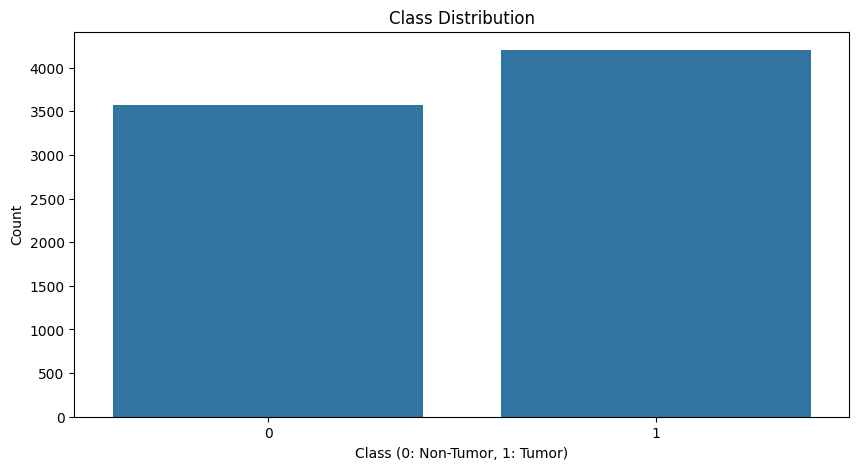

Class Distribution:
Class 0: 3570 images (45.94%)
Class 1: 4201 images (54.06%)


In [30]:
# Set paths
excel_path = 'Dataset/00Kidney_Patients.xlsx'
images_root_path = 'unzipped_scans'

# Create dataset instance
kidney_dataset = KidneyTumorDataset(excel_path, images_root_path)

# Check total number of images
print(f"Total number of images: {len(kidney_dataset)}")

# Visualize class distribution
kidney_dataset.get_class_distribution()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


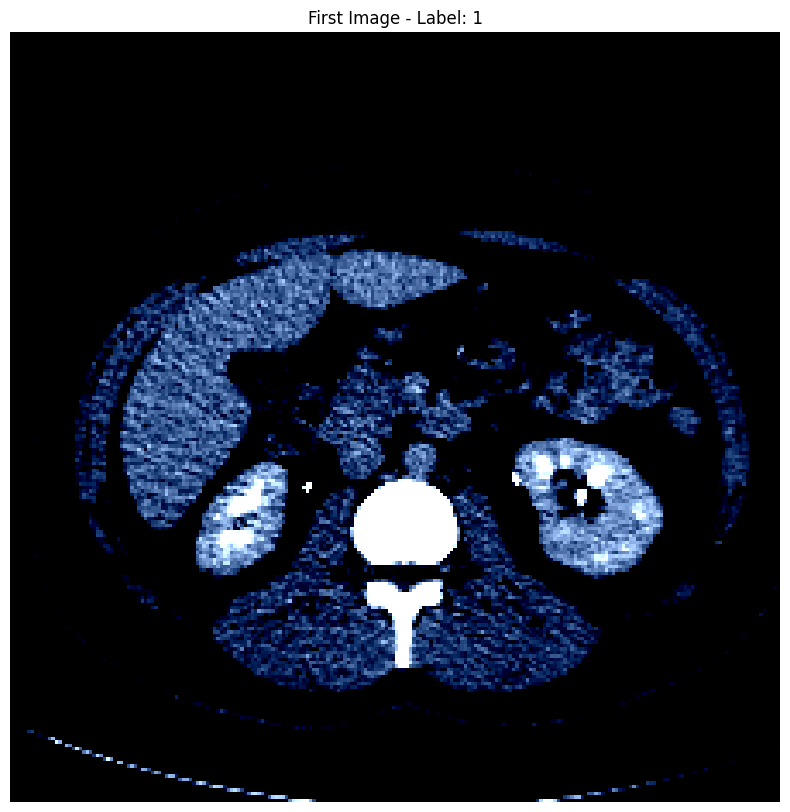

First image path: unzipped_scans\01\1\00000001.jpg
First image shape: torch.Size([3, 224, 224])
First image label: 1


In [22]:
# Test image loading
try:
    # Load first image to verify
    first_image, first_label = kidney_dataset[0]
    
    # Visualize the first image
    plt.figure(figsize=(10, 10))
    plt.imshow(first_image.permute(1, 2, 0).numpy())
    plt.title(f"First Image - Label: {first_label}")
    plt.axis('off')
    plt.show()
    
    print(f"First image path: {kidney_dataset.image_paths[0]}")
    print(f"First image shape: {first_image.shape}")
    print(f"First image label: {first_label}")
except Exception as e:
    print(f"Error loading image: {e}")